In [1]:
import sys
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy.ndimage import zoom
from scipy import spatial
from copy import copy
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape
import subprocess
from IPython.display import display, clear_output #needed for animated plots
from inpaint_nans import inpaint_nans

In [2]:
nan_value = -9999
resample = .25
res = 50 / resample

mar = np.loadtxt("01_margin_Synthetic3_0000_UTM00.csv", skiprows=0, unpack=True, delimiter=';')
S_ref = np.flip(np.loadtxt("02_surface_Synthetic3_0000_UTM00.asc", skiprows=6), axis=0)
S_ref[S_ref == nan_value] = 0
S_ref = zoom(S_ref, resample)
M_ref = np.flip(np.loadtxt("04_mb_Synthetic3_0000-0001_UTM00.asc", skiprows=6), axis=0)
M_ref[M_ref == nan_value] = 0
M_ref = zoom(M_ref, resample)
dhdt_ref = np.flip(np.loadtxt("05_dhdt_Synthetic3_0000-0001_UTM00.asc", skiprows=6), axis=0)
dhdt_ref[dhdt_ref == nan_value] = 0
dhdt_ref = zoom(dhdt_ref, resample)
u_ref = np.flip(np.loadtxt("06_speed_Synthetic3_0000_UTM00.asc", skiprows=6), axis=0)
u_ref[u_ref == nan_value] = 0
u_ref = zoom(u_ref, resample)
az_ref = np.flip(np.loadtxt("07_azimuth_Synthetic3_0000_UTM00.asc", skiprows=6), axis=0)
az_ref[az_ref == nan_value] = 0
az_ref = zoom(az_ref, resample)
u_vel_ref = np.cos(1-np.deg2rad(az_ref))*u_ref
v_vel_ref = np.cos(np.deg2rad(az_ref))*u_ref

ny, nx = np.shape(S_ref)

outline = shapefile.Reader("./shapefiles/01_margin_Synthetic3_0000_UTM00.shp").shapes()[0]
mask = np.zeros_like(S_ref)
for j in range(1,np.shape(mask)[0]-1):
    for k in range(1,np.shape(mask)[1]-1):
        if Point([((k-0*resample)*res)+outline.bbox[0],((j-8*resample)*res)+outline.bbox[1]]).within(shape(outline)):
            mask[j,k] = 1

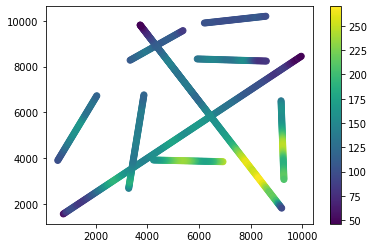

In [3]:
pNR, dist, x_coord, y_coord, z_surf, z_bed, thick = np.loadtxt("03_RES_Synthetic3_UTM00.txt", skiprows=17, unpack=True)
Pro = np.unique(pNR)
nPro = len(Pro)
indPro = []
count = 0
for i in Pro:
    indPro.append(len(pNR[pNR==i])+count)
    count+=i

fig, ax = plt.subplots()
field = ax.scatter(x_coord, y_coord, c=thick)
fig.colorbar(field)

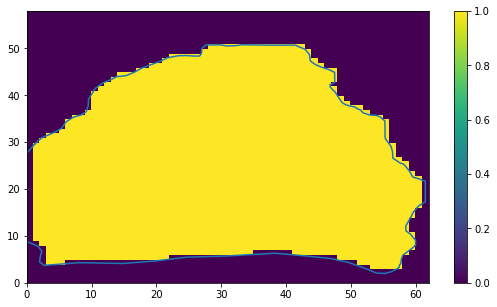

In [4]:
x = [(i[0]-outline.bbox[0])/res+0*resample for i in (outline).points[:]]
y = [(i[1]-outline.bbox[1])/res+8*resample for i in (outline).points[:]]
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x,y)
field = ax.pcolor(mask)
fig.colorbar(field)

In [5]:
ice_temp = 270
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))
print(A)

2.001246464303045e-24


In [6]:
filename = "synthetic_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         #"geometry.ice_free_thickness_standard": 30,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [7]:
WRIT_FILE = 'synthetic_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

Lx = nx * res  # in m
Ly =  ny * res # in m

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx/2, Lx/2, nx)
y = np.linspace(-Ly/2, Ly/2, ny)

B_rec = S_ref
B_init = copy(B_rec)
ice_surface_temp = np.ones((ny, nx))*273
land_ice_area_fraction_retreat = np.ones_like(S_ref)
M_ref = np.nan_to_num(M_ref)
M_ref *= mask

h_rec = S_ref - B_rec

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['km',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['km',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'ice thickness',
                 'land_ice_thickness',
                 1.0,
                 h_rec],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_rec],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  M_ref * ice_density],
        'land_ice_area_fraction_retreat': ['',
                                  'maximum ice extent mask',
                                  'land_ice_area_fraction_retreat',
                                  0,
                                  mask],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  synthetic_initialSetup.nc  created



In [8]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 10 -Mbz 1 -Lz 1000 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('OCEAN="-dry"')
    print('CONF="-config_override synthetic_conf.nc"')# -front_retreat_file synthetic_max_extent.nc -geometry.front_retreat.prescribed.period 100"')
    #print('DIF="-limit_sia_diffusivity -stress_balance.sia.max_diffusivity $OPT5 -time_stepping.adaptive_ratio 0.12"')
    #print('ENHANCE="-sia_e 1e5 -sia_n 2 -ssa_e 10"')
    
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 2e7"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize synthetic glacier"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [9]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('synthetic_initialize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()
    
!chmod +x synthetic_initialize.sh
!./synthetic_initialize.sh 4 synthetic_initialSetup.nc 1 synthetic_output.nc > synthetic_output_log.txt

In [10]:
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = ds[var][time][:]
    return var_data

def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))
def scale_negpos(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))+(np.nanmax(x)/np.nanmin(x))/2

In [11]:
## shifted dhdt-field
from scipy.interpolate import griddata

def shift(data, u, v):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
    x_shift = x_shift+(u/uv_mag)*0.3
    y_shift = y_shift+(v/uv_mag)*0.3

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten())).reshape(np.shape(u))
    return newgrid

In [12]:
def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

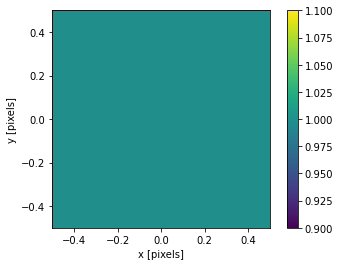

In [13]:
gaussian_2D_kernel = gauss2D((int(250/res),int(250/res)), 1)
plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

1.3535983636029532
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
1.3137705608864092
130.19518


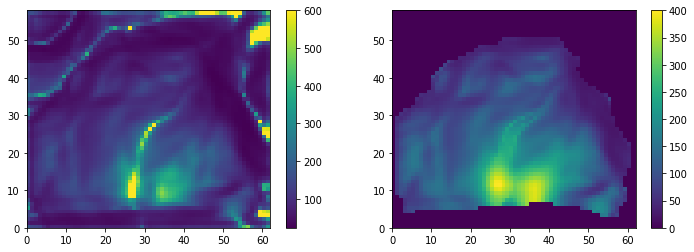

In [56]:
import richdem as rd
import math

dH = (np.nanmax(S_ref[mask==1])-np.nanmin(S_ref[mask==1]))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle
print(tau)

slope = rd.TerrainAttribute(rd.rdarray(S_ref, no_data=-9999), attrib='slope_riserun')
tan_slope = np.arctan(slope/res)
sin_slope = np.sin(tan_slope)
H=(tau)*1e5/(sin_slope*9.81*ice_density)
H[np.isnan(H)]=0
fig, ax = plt.subplots(1,2, figsize=(12,4))
field = ax[0].pcolor(H, vmax=600)
fig.colorbar(field,ax=ax[0])
print(dH)
print(np.mean(H))

def smooth_stress_coupling(H, field, mask, scl, max_scl):
    field_new = np.zeros_like(field)
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                field_new[j,i] = field[j,i]
            else:
                x, y = np.ogrid[:np.shape(H)[0], :np.shape(H)[1]]
                coupling_length = scl*(H[j,i]/res)**2
                circle = (y - i) ** 2 + (x - j) ** 2 <= (min(coupling_length,max_scl)/2)**2
                field_new[j,i]= np.mean(field[np.logical_and(circle, mask==1)])
    return field_new
            
sin_slope_smooth = smooth_stress_coupling(H, sin_slope, mask, 4, 8)
H_smooth=(tau)*1e5/(sin_slope_smooth*9.81*ice_density)
field = ax[1].pcolor(H_smooth*mask)
fig.colorbar(field, ax=ax[1])

In [15]:
import scipy.sparse as sps
from scipy.sparse import linalg
from numpy import matlib

In [228]:
### bed recovery ###
from scipy.signal import spline_filter

S_ref = np.flip(np.loadtxt("02_surface_Synthetic3_0000_UTM00.asc", skiprows=6), axis=0)
S_ref[S_ref == nan_value] = 0
S_ref = zoom(S_ref, resample)
S_rec = copy(S_ref)

B_rec = B_rec = np.maximum(S_ref-300, S_ref-H_smooth*mask)
B_init = copy(B_rec)

dh_ref = copy(dhdt_ref*mask)

B_rec_all = []
S_rec_all = []
dh_all = []
misfit_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]

pmax = 500
dt = .1
beta = .5
bw = 2

!cp synthetic_output.nc synthetic_iteration_out.nc
    
original_stdout = sys.stdout
with open('synthetic_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_iteration_script.sh

In [229]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
    
    !cp synthetic_iteration_out.nc synthetic_iteration_in.nc
    nc_updated = NC('synthetic_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated.close()
    
    cmd = ["./synthetic_iteration_script.sh", '3', 'synthetic_iteration_in.nc', str(dt), 'synthetic_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('synthetic_iteration_log.txt', 'a'))
    
    h_rec = get_nc_data('synthetic_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('synthetic_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)

    u = get_nc_data('synthetic_iteration_out.nc', 'uvelsurf', 0)
    u[criterion] = 0
    v = get_nc_data('synthetic_iteration_out.nc', 'vvelsurf', 0)
    v[criterion] = 0
    misfit = shift((dh_rec-dh_ref), u, v)
    
    #misfit = spline_filter(misfit, lmbda=1)
    #misfit_back = fourier_misfit(misfit+np.min(misfit))
    #misfit = ((-misfit_back/np.max(misfit_back))*(np.max(misfit)-np.min(misfit)))+np.max(misfit)
    #misfit = smooth_stress_coupling(misfit, misfit, mask, 6, 8)

    
    B_rec -= beta * (misfit)

    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.04) * misfit[np.logical_and(mask==1, h_rec>20)] 
    
    B_rec = ndimage.gaussian_filter(B_rec, .3)
    
    #if p%100 == 0:
    #    B_rec = spline_filter(B_rec, lmbda=1)
    
    ### buffer ###

    h_inpaint = S_rec-B_rec
    h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    h_inpaint = inpaint_nans(h_inpaint)
    B_rec = S_rec - h_inpaint
    ### buffer end ###
    
    #B_rec[mask==1]=np.minimum(S_ref[mask==1]-50, B_rec[mask==1])
    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[B_rec>S_ref]=S_ref[B_rec>S_ref]
    B_rec[mask == 0]= S_ref[mask == 0]
    S_rec[mask == 0]= S_ref[mask == 0]
    
    B_rec_all.append(B_rec)
    S_rec_all.append(S_rec)
    dh_all.append(dh_rec)
    misfit_all.append(misfit)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec-B_init)))
    dh_misfit_vs_iter.append(np.mean(abs(misfit)))

  0%|          | 0/500 [00:00<?, ?it/s]/home/thomas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


In [90]:
#misfit1 = ((-misfit_back/np.max(misfit_back))*(np.max(misfit)-np.min(misfit)))+np.max(misfit)
t = shift((dh_rec-dh_ref), u, v)
t = smooth_stress_coupling(h_rec, t, mask, 6, 8)

/home/thomas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


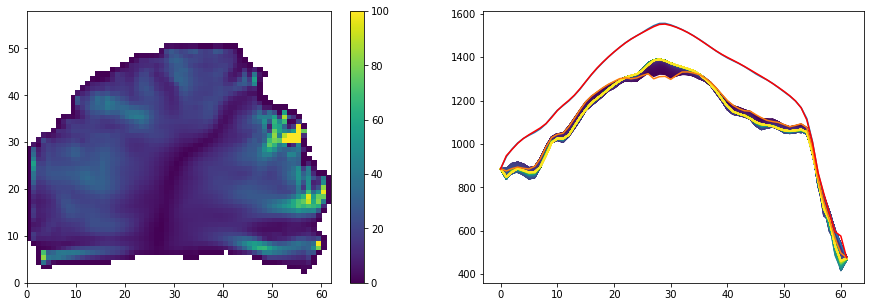

In [239]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(get_nc_data('synthetic_iteration_out.nc', 'velsurf_mag', 0), vmax=100)#, cmap='RdBu', vmin=-10, vmax=10)#spline_filter(S_ref-B_rec_all[-1], lmbda=1))
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),1):
    lines = axes[1].plot(range(nx), B_rec_all[i][20,:], color=colors[i])
lines2 = axes[1].plot(range(nx), S_ref[20,:])
lines2 = axes[1].plot(range(nx), B_init[20,:])
lines4 = axes[1].plot(range(nx), S_rec[20,:], color='r')

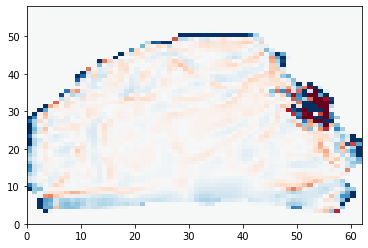

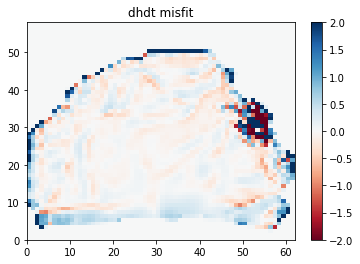

In [215]:
fig, axes = plt.subplots()
for i in range(0,len(B_rec_all),5):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-2, vmax=2)
    #field = axes.pcolor(S_ref - B_rec_all[i], vmax=300)
    clear_output(wait=True)
    display(fig)
axes.set_title('dhdt misfit')
fig.colorbar(field)

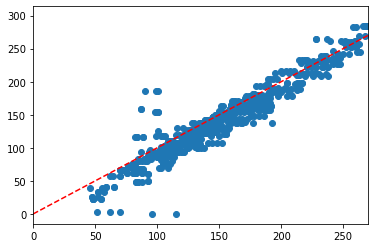

In [231]:
x_new = ((x_coord-outline.bbox[0])/res+0*resample).astype('int')
y_new = ((y_coord-outline.bbox[1])/res+8*resample).astype('int')
cors = []
thk_rec_all = []
for i in range(0,len(B_rec_all),1):
    thk_rec = S_rec_all[i] - B_rec_all[i]#spline_filter(S_ref-B_rec_all[i], lmbda=1)
    thk_rec_all.append(thk_rec)
    cors.append(np.corrcoef(thick, thk_rec[y_new,x_new])[0][1])

fig, ax = plt.subplots()
field = ax.scatter(thick, thk_rec_all[200][y_new, x_new])
#ax.set_aspect(1)
ax.set_xlim([0,np.max(thick)])
#ax.set_ylim([0,np.max(thick)])
ax.plot(range(300), range(300), 'r', linestyle='--')

(0.0, 100.0)

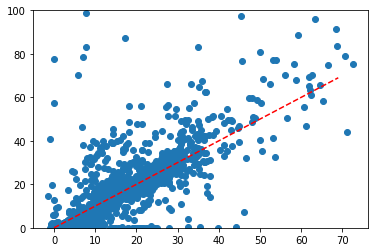

In [237]:
fig, ax = plt.subplots()
field = ax.scatter(u_ref, get_nc_data('synthetic_iteration_out.nc', 'velsurf_mag', 0))
ax.plot(range(70), range(70), 'r', linestyle='--')
ax.set_ylim([0,100])

Text(0.5, 1.0, 'histogram of deviations')

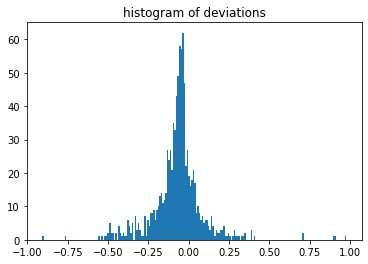

In [217]:
fig, ax = plt.subplots()
ax.hist(dev, bins = 200)
ax.set_title('histogram of deviations')

In [232]:
import numpy as np, scipy.stats as st
max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thk_rec_all[-1][y_new,x_new]-thick)/126.4 #126.4 is mean thickness according to ITMIX2
mean_dev = np.nanmean((dev))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
print('mean deviation: {}'.format(mean_dev))
print('median deviation: {}'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

mean deviation: -0.07302529221930207
median deviation: -0.07437852308471507
Interquartile range of deviation: 0.10155909469466873
95% confidence intervall: [ 0.00722373 -0.00722373]


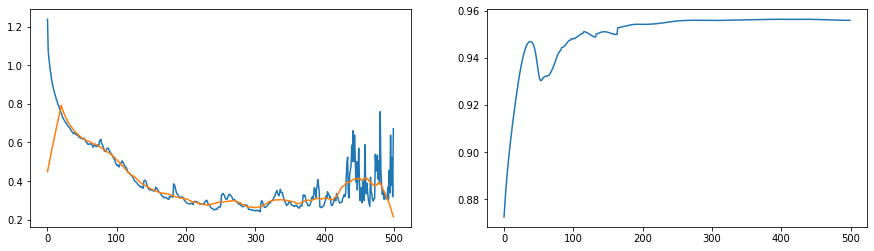

In [233]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(dh_misfit_vs_iter)
line1 = ax[0].plot(np.convolve(dh_misfit_vs_iter, np.ones(40)/40, mode='same'))
line2 = ax[1].plot(cors)

In [157]:
import cv2

img = misfit.copy() # load an image
def fourier_misfit(img):
    #Output is a 2D complex array. 1st channel real and 2nd imaginary
    #For fft in opencv input image needs to be converted to float32
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    
    #Rearranges a Fourier transform X by shifting the zero-frequency 
    #component to the center of the array.
    #Otherwise it starts at the tope left corenr of the image (array)
    dft_shift = np.fft.fftshift(dft)
    
    ##Magnitude of the function is 20.log(abs(f))
    #For values that are 0 we may end up with indeterminate values for log. 
    #So we can add 1 to the array to avoid seeing a warning. 
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    
    
    # Circular HPF mask, center circle is 0, remaining all ones
    #Can be used for edge detection because low frequencies at center are blocked
    #and only high frequencies are allowed. Edges are high frequency components.
    #Amplifies noise.
    """"
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    
    maskf = np.ones((rows, cols, 2), np.uint8)
    r = 80
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    maskf[mask_area] = 0
    
    
    # Circular LPF mask, center circle is 1, remaining all zeros
    # Only allows low frequency components - smooth regions
    #Can smooth out noise but blurs edges.
    #
    """
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    maskf = np.zeros((rows, cols, 2), np.uint8)
    r = 12
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    maskf[mask_area] = 1
    # Band Pass Filter - Concentric circle mask, only the points living in concentric circle are ones
    """
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    mask = np.zeros((rows, cols, 2), np.uint8)
    r_out = 10
    r_in = 10
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                               ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
    maskf[mask_area] = 1
    """
    
    
    # apply mask and inverse DFT: Multiply fourier transformed image (values)
    #with the mask values. 
    fshift = dft_shift * maskf
    
    #Get the magnitude spectrum (only for plotting purposes)
    fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))
    
    #Inverse shift to shift origin back to top left.
    f_ishift = np.fft.ifftshift(fshift)
    
    #Inverse DFT to convert back to image domain from the frequency domain. 
    #Will be complex numbers
    img_back = cv2.idft(f_ishift)
    
    #Magnitude spectrum of the image domain
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    return img_back

"""""
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(2,2,1)
    field = ax1.imshow(img)
    fig.colorbar(field,ax=ax1)
    ax1.title.set_text('Input Image')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(magnitude_spectrum)
    ax2.title.set_text('FFT of image')
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(fshift_mask_mag)
    ax3.title.set_text('FFT + Mask')
    ax4 = fig.add_subplot(2,2,4)
    field=ax4.imshow(((-img_back/np.max(img_back))*(np.max(img)-np.min(img)))+np.max(img))
    ax4.title.set_text('After inverse FFT')
    fig.colorbar(field, ax=ax4)
    plt.show()
"""""

'""\n    fig = plt.figure(figsize=(12, 12))\n    ax1 = fig.add_subplot(2,2,1)\n    field = ax1.imshow(img)\n    fig.colorbar(field,ax=ax1)\n    ax1.title.set_text(\'Input Image\')\n    ax2 = fig.add_subplot(2,2,2)\n    ax2.imshow(magnitude_spectrum)\n    ax2.title.set_text(\'FFT of image\')\n    ax3 = fig.add_subplot(2,2,3)\n    ax3.imshow(fshift_mask_mag)\n    ax3.title.set_text(\'FFT + Mask\')\n    ax4 = fig.add_subplot(2,2,4)\n    field=ax4.imshow(((-img_back/np.max(img_back))*(np.max(img)-np.min(img)))+np.max(img))\n    ax4.title.set_text(\'After inverse FFT\')\n    fig.colorbar(field, ax=ax4)\n    plt.show()\n'